# ARIMA and Seasonal ARIMA

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
sns.set_theme(style = 'darkgrid')

In [2]:
dataset = pd.read_csv('C:/pandas/perrin-freres-monthly-champagne-.csv')

## Checking Data Quality

In [3]:
dataset.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
dataset.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [6]:
dataset.duplicated().sum()

0

## Cleaning Data

In [7]:
dataset.columns = ['Month', 'Sales']

In [8]:
dataset.drop([105,106], axis=0, inplace=True)
dataset.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [9]:
dataset['Month'] = pd.to_datetime(dataset['Month'])

In [10]:
dataset.set_index('Month', inplace=True)

In [11]:
dataset.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


## Visualize the Data

In [12]:
def create_lineplot(dataset, col, figsize):
    plt.figure(figsize = figsize)
    sns.lineplot(x = dataset.index, y = dataset[col])

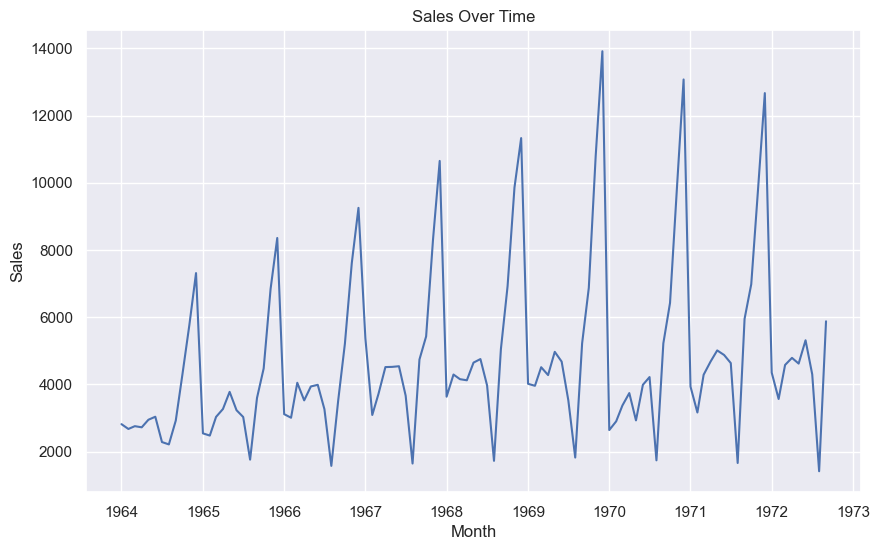

In [13]:
create_lineplot(dataset, 'Sales', (10, 6))
plt.title('Sales Over Time')
plt.show()

## Testing for Stationarity

In [14]:
test_result=adfuller(dataset['Sales'])

In [15]:
# Ho: It is NON stationary
# H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels=['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label, in zip(result, labels):
        print(label +' : ' + str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary')

In [16]:
adfuller_test(dataset['Sales'])

ADF Test Statistic : -1.833593056327623
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary


```
The p-value indicates we cannot reject the null hypothesis, meaning the sales data is non-stationary. To make it suitable for modeling, we need to remove trends and seasonality through transformations.
```

## Differencing Dataset

In [17]:
def differencing(dataset, col, new_cols, lags):
    for new_col, lag in zip(new_cols, lags):
        dataset[new_col] = dataset[col] - dataset[col].shift(lag)

In [18]:
col = ['Sales First Difference', 'Seasonal First Difference']
lag = [1,12]

differencing(dataset, 'Sales', col, lag)

In [19]:
adfuller_test(dataset['Sales First Difference'].dropna())

ADF Test Statistic : -7.189896448051016
p-value : 2.519620447386879e-10
#Lags Used : 11
Number of Observations Used : 92
Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary


In [20]:
adfuller_test(dataset['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary


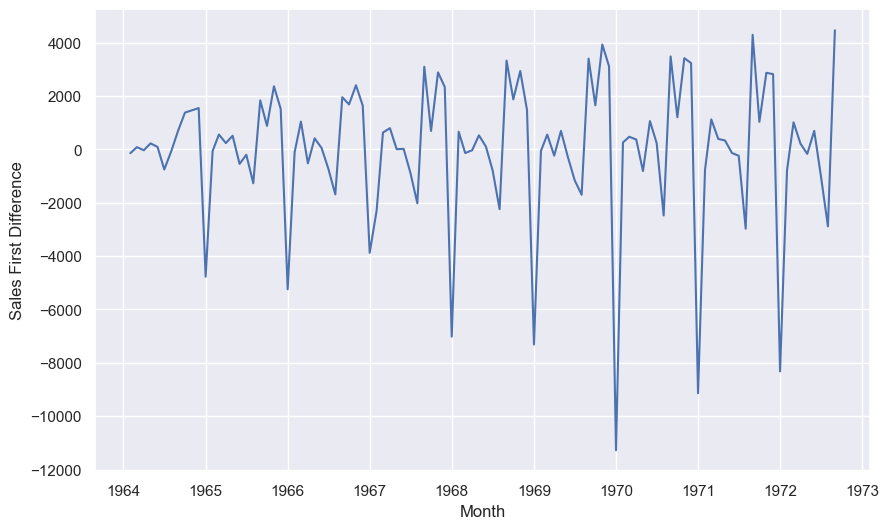

In [21]:
create_lineplot(dataset, 'Sales First Difference', (10,6))

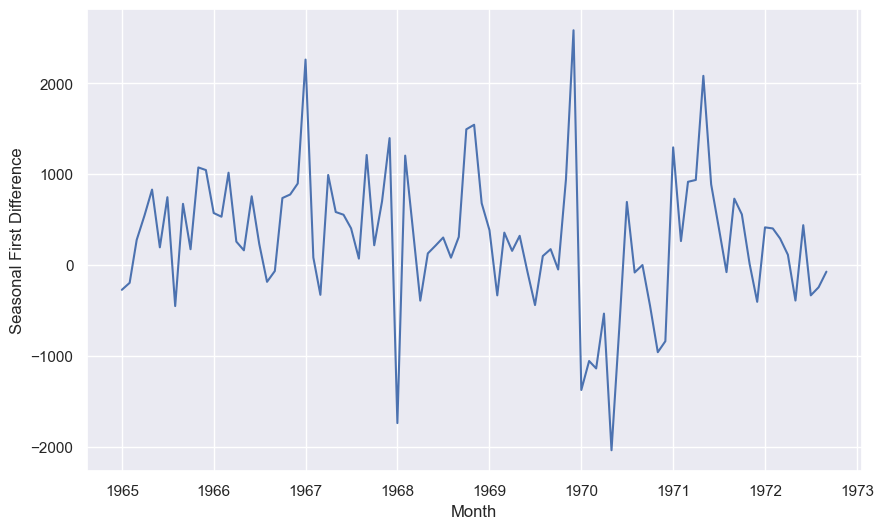

In [22]:
create_lineplot(dataset, 'Seasonal First Difference', (10, 6))

```
The first difference removes the trend but still shows seasonality. The second plot indicates the data is more stationary, so a SARIMA model would be suitable for making predictions.
```

## Auto Regressive Model
$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t
$$

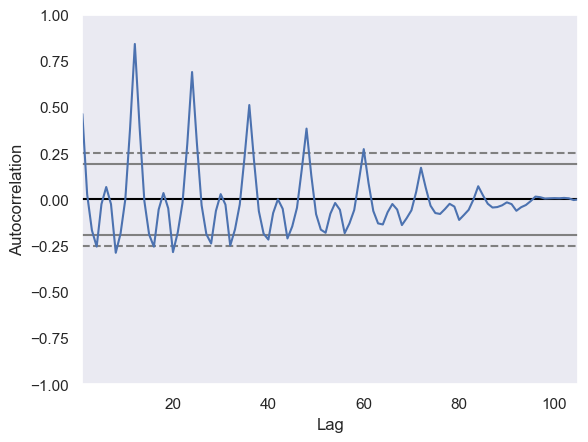

In [23]:
autocorrelation_plot(dataset['Sales'])
plt.show()

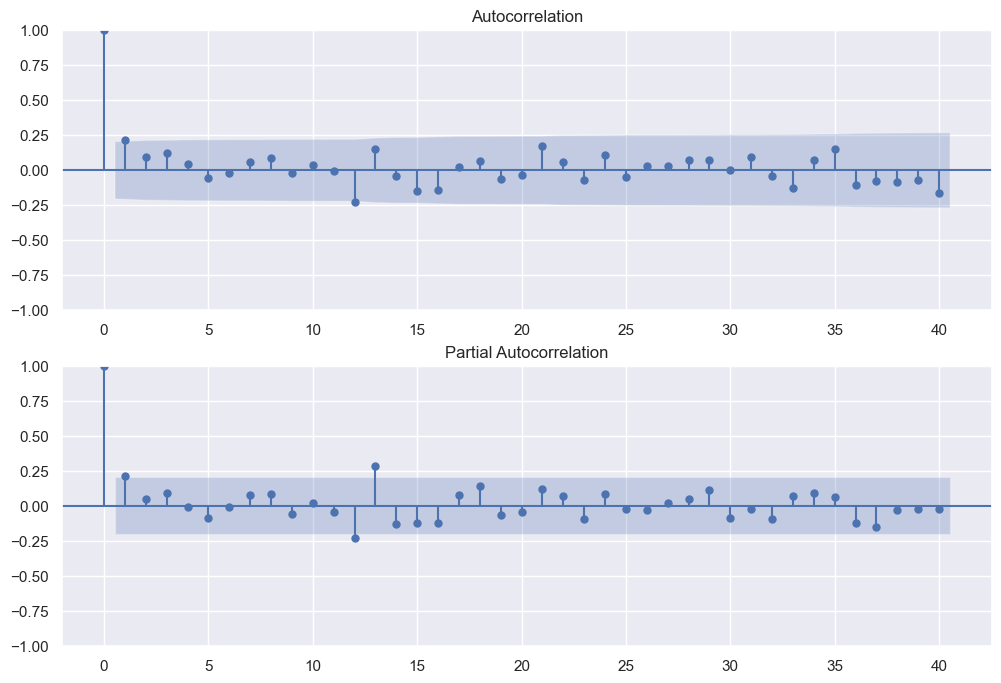

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

In [25]:
# For non-seasonal data (ARIMA only suitable for non-seasonal data, HERE using ARIMA is just shows how to use ARIMA)
#p=1, d=1, q=0 or 1
model=ARIMA(dataset['Sales'],order=(1,1,1))
model_fit=model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Thu, 26 Dec 2024   AIC                           1911.627
Time:                        23:31:11   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
def forecast_and_plot(dataset, model_fit, col, start, end, figsize, dynamic = True):
    dataset['forecast'] = model_fit.predict(start = start, end = end, dynamic = True)
    dataset[[col, 'forecast']].plot(figsize = figsize)

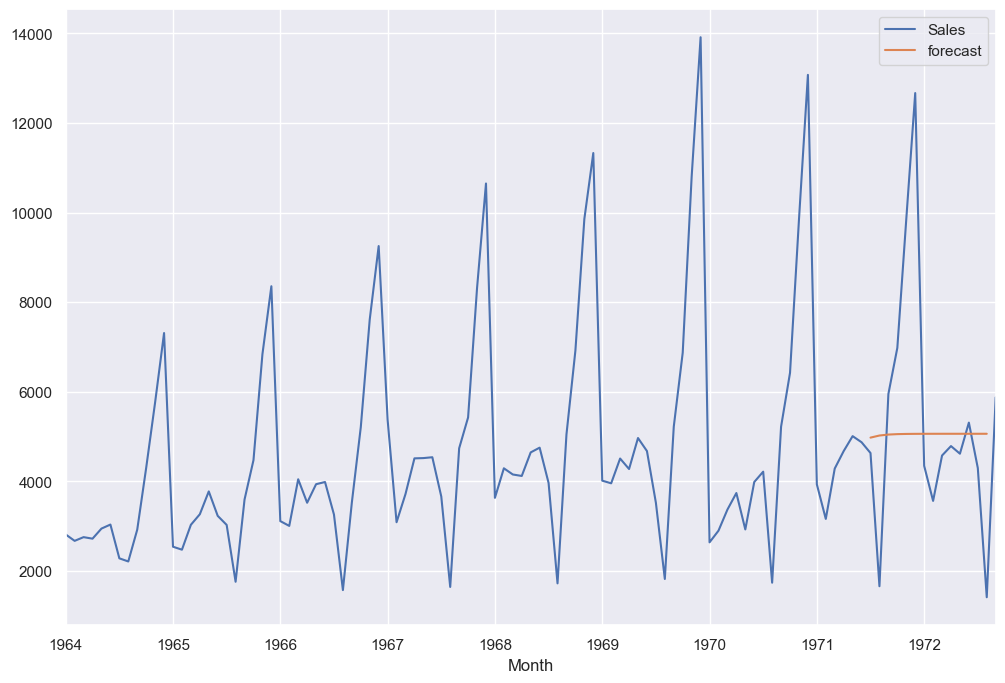

In [28]:
forecast_and_plot(dataset, model_fit, 'Sales', 90, 103, (12,8))

```
The forecast fails to fully capture the seasonal variations, indicating SARIMA model would be more suitable in this case.
```

In [29]:
model=sm.tsa.statespace.SARIMAX(dataset['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


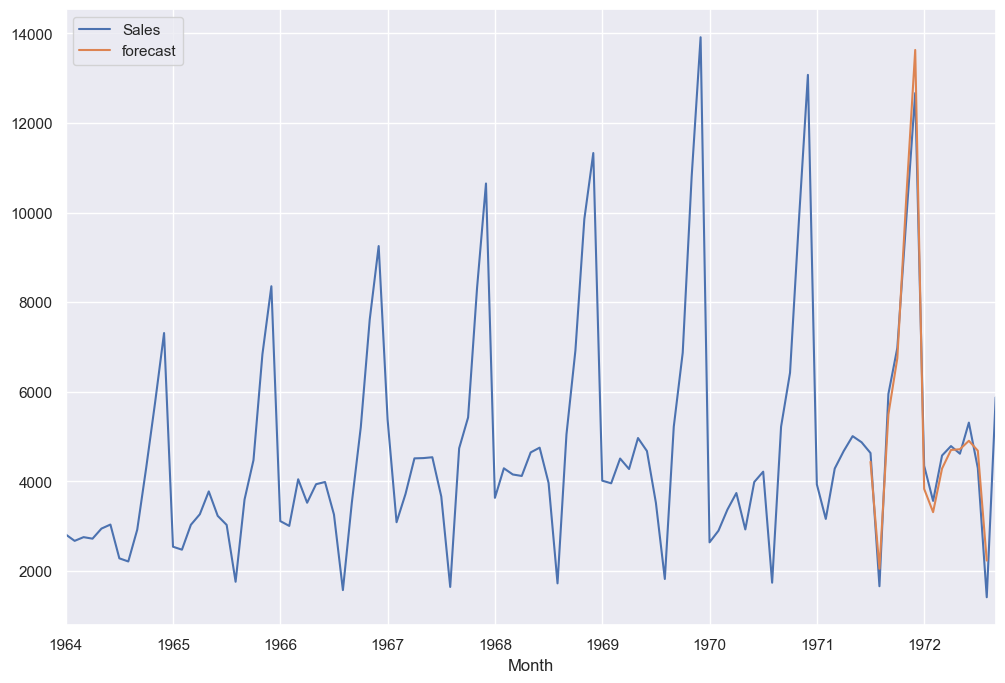

In [30]:
forecast_and_plot(dataset, results, 'Sales', 90, 103, (12,8))

```
The forecast captures the seasonal patterns, indicating that it can enhance model performance for future time series predictions.
```

In [31]:
future_dates = []

for x in range(0,24): 
    future_dates.append(dataset.index[-1]+ DateOffset(months=x))

In [32]:
future_datest_df=pd.DataFrame(index = future_dates[1:], columns=dataset.columns)

In [33]:
future_datest_df.tail()

,Sales,Sales First Difference,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [34]:
future_df=pd.concat([dataset,future_datest_df])
future_df

C:\Users\user\AppData\Local\Temp\ipykernel_14780\1436045221.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([dataset,future_datest_df])


,Sales,Sales First Difference,Seasonal First Difference,forecast
1964-01-01,2815.0,NaN,NaN,NaN
1964-02-01,2672.0,-143.0,NaN,NaN
1964-03-01,2755.0,83.0,NaN,NaN
1964-04-01,2721.0,-34.0,NaN,NaN
1964-05-01,2946.0,225.0,NaN,NaN
...,...,...,...,...
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN


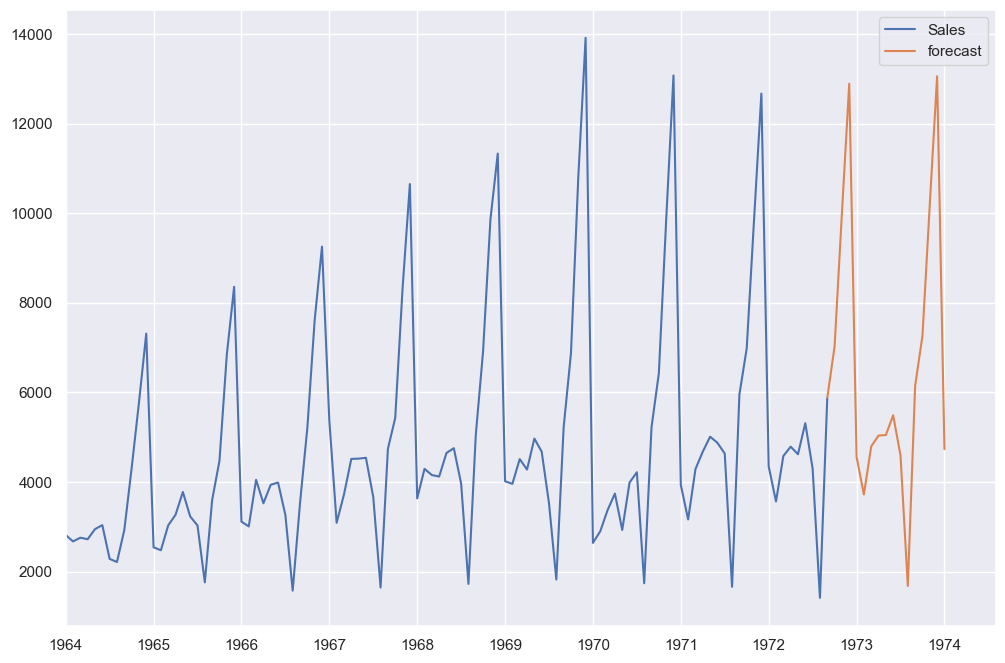

In [35]:
forecast_and_plot(future_df, results, 'Sales', 104, 120, (12,8))